In [1]:
import msprime as msp
import demes
import demesdraw

demo = msp.Demography()
demo.add_population(initial_size = 5000, name = "anc")
demo.add_population(initial_size = 5000, name = "P0")
demo.add_population(initial_size = 5000, name = "P1")
demo.set_symmetric_migration_rate(populations=("P0", "P1"), rate=0.001)
tmp = [f"P{i}" for i in range(2)]
demo.add_population_split(time = 1000, derived=tmp, ancestral="anc")
g = demo.to_demes()
sample_size = 10
samples = {f"P{i}": sample_size for i in range(2)}
anc = msp.sim_ancestry(samples=samples, demography=demo, recombination_rate=1e-8, sequence_length=1e8, random_seed = 12)
ts = msp.sim_mutations(anc, rate=1e-8, random_seed = 13)

afs_samples = {f"P{i}": sample_size*2 for i in range(2)}
afs = ts.allele_frequency_spectrum(sample_sets=[ts.samples([1]), ts.samples([2])], span_normalise=False)

In [3]:
from __future__ import annotations

from typing import Any, Dict, List, Mapping, Optional, Sequence, Set, Tuple

import jax
import jax.numpy as jnp
import msprime as msp
from scipy.optimize import LinearConstraint, minimize
import jax.random as jr
from jax import vmap, lax 

from demesinfer.coal_rate import PiecewiseConstant
from demesinfer.constr import EventTree, constraints_for
from demesinfer.iicr import IICRCurve
from demesinfer.loglik.arg import loglik
from jax.scipy.special import xlogy
from demesinfer.sfs import ExpectedSFS

Path = Tuple[Any, ...]
Var = Path | Set[Path]
Params = Mapping[Var, float]

def _dict_to_vec(d: Params, keys: Sequence[Var]) -> jnp.ndarray:
    return jnp.asarray([d[k] for k in keys], dtype=jnp.float64)

def _vec_to_dict_jax(v: jnp.ndarray, keys: Sequence[Var]) -> Dict[Var, jnp.ndarray]:
    return {k: v[i] for i, k in enumerate(keys)}

def _vec_to_dict(v: jnp.ndarray, keys: Sequence[Var]) -> Dict[Var, float]:
    return {k: float(v[i]) for i, k in enumerate(keys)}

def compile(ts, subkey):
    # using a set to pull out all unique populations that the samples can possibly belong to
    pop_cfg = {ts.population(ts.node(n).population).metadata["name"] for n in ts.samples()}
    pop_cfg = {pop_name: 0 for pop_name in pop_cfg}

    samples = jax.random.choice(subkey, ts.num_samples, shape=(2,), replace=False)
    a, b = samples[0].item(0), samples[1].item(0)
    spans = []
    curr_t = None
    curr_L = 0.0
    for tree in ts.trees():
        L = tree.interval.right - tree.interval.left
        t = tree.tmrca(a, b)
        if curr_t is None or t != curr_t:
            if curr_t is not None:
                spans.append([curr_t, curr_L])
            curr_t = t
            curr_L = L
        else:
            curr_L += L
    spans.append([curr_t, curr_L])
    data = jnp.asarray(spans, dtype=jnp.float64)
    pop_cfg[ts.population(ts.node(a).population).metadata["name"]] += 1
    pop_cfg[ts.population(ts.node(b).population).metadata["name"]] += 1
    return data, pop_cfg

def get_tmrca_data(ts, key, num_samples):
    data_list = []
    cfg_list = []
    max_indices = []
    for i in range(num_samples):
        key, subkey = jr.split(key)
        data, cfg = compile(ts, subkey)
        data_list.append(data)
        cfg_list.append(cfg)
        max_indices.append(data.shape[0] - 1)

    lens = jnp.array([d.shape[0] for d in data_list], dtype=jnp.int32)
    Lmax = int(lens.max())
    Npairs = len(data_list)
    data_pad = jnp.full((Npairs, Lmax, 2), jnp.array([1.0, 0.0]), dtype=jnp.float64)

    for i, d in enumerate(data_list):
        data_pad = data_pad.at[i, : d.shape[0], :].set(d)

    deme_names = cfg_list[0].keys()
    D = len(deme_names)
    cfg_mat = jnp.zeros((num_samples, D), dtype=jnp.int32)
    for i, cfg in enumerate(cfg_list):
        for j, n in enumerate(deme_names):
            cfg_mat = cfg_mat.at[i, j].set(cfg.get(n, 0))

    unique_cfg = jnp.unique(cfg_mat, axis=0)

    # Find matching indices
    def find_matching_index(row, unique_arrays):
        matches = jnp.all(row == unique_arrays, axis=1)
        return jnp.where(matches)[0][0]

    # Vectorize over all rows in `arr`
    matching_indices = jnp.array([find_matching_index(row, unique_cfg) for row in cfg_mat])
    
    return data_pad, cfg_mat, deme_names, jnp.array(max_indices), unique_cfg, matching_indices

def plot_iicr_likelihood(demo, ts, paths, vec_values, recombination_rate=1e-8, seed=1, num_samples=20, t_min=1e-8, num_t=1000, k=2):
    import matplotlib.pyplot as plt

    key = jr.PRNGKey(seed)
    path_order: List[Var] = list(paths)
    data_pad, cfg_mat, deme_names, max_indices, unique_cfg, matching_indices = get_tmrca_data(ts, key, num_samples)
    first_columns = data_pad[:, :, 0]
    # Compute global max (single float value)
    global_max = jnp.max(first_columns)
    print(global_max)
    t_breaks = jnp.insert(jnp.geomspace(t_min, global_max * 2, num_t), 0, 0.0)
    rho = recombination_rate
    iicr = IICRCurve(demo=demo, k=k)
    iicr_call = jax.jit(iicr.__call__)

    def compute_loglik(c_map, c_index, data, max_index):
        c = c_map[c_index]
        eta = PiecewiseConstant(c=c, t=t_breaks)
        return loglik(eta, rho, data, max_index)
    
    def evaluate_at_vec(vec):
        vec_array = jnp.atleast_1d(vec)
        params = _vec_to_dict_jax(vec_array, path_order)

        # def compute_c(sample_config):
        #     # Convert sample_config (array) to dictionary of population sizes
        #     ns = {name: sample_config[i] for i, name in enumerate(deme_names)}
            
        #     # Compute IICR and log-likelihood
        #     c = iicr_call(params=params, t=t_breaks, num_samples=ns)["c"]
        #     return c
        # c_map = vmap(compute_c, in_axes=(0))(unique_cfg)
        c_map = jax.vmap(lambda cfg: iicr_call(params=params, t=t_breaks, num_samples=dict(zip(deme_names, cfg)))["c"])(
            jnp.array(unique_cfg)
        )
        
        # Batched over cfg_mat and all_tmrca_spans 
        batched_loglik = vmap(compute_loglik, in_axes=(None, 0, 0, 0))(c_map, matching_indices, data_pad, max_indices)
        return -jnp.sum(batched_loglik) / num_samples  # Same as original neg_loglik

    # Outer vmap: Parallelize across vec_values
    batched_neg_loglik = vmap(evaluate_at_vec)  # in_axes=0 is default

    # 3. Compute all values (runs on GPU/TPU if available)
    results = batched_neg_loglik(vec_values) 
    # results = lax.map(evaluate_at_vec, vec_values)

    # 4. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(vec_values, results, 'r-', linewidth=2)
    plt.xlabel("vec value")
    plt.ylabel("Negative Log-Likelihood")
    plt.title("IICR Likelihood Landscape")
    plt.grid(True)
    plt.show()

    return results

def plot_sfs_likelihood(demo, paths, vec_values, afs, afs_samples, theta=None, sequence_length=None):
    import matplotlib.pyplot as plt

    path_order: List[Var] = list(paths)
    esfs = ExpectedSFS(demo, num_samples=afs_samples)

    def sfs_loglik(afs, esfs, sequence_length=None, theta=None):
        afs = afs.flatten()[1:-1]
        esfs = esfs.flatten()[1:-1]
        
        if theta:
            assert(sequence_length)
            tmp = esfs * sequence_length * theta
            return jnp.sum(-tmp + xlogy(afs, tmp))
        else:
            return jnp.sum(xlogy(afs, esfs/esfs.sum()))
    
    def evaluate_at_vec(vec):
        vec_array = jnp.atleast_1d(vec)
        params = _vec_to_dict_jax(vec_array, path_order)
        e1 = esfs(params)
        return -sfs_loglik(afs, e1)

    # Outer vmap: Parallelize across vec_values
    batched_neg_loglik = vmap(evaluate_at_vec)  # in_axes=0 is default

    # 3. Compute all values (runs on GPU/TPU if available)
    results = batched_neg_loglik(vec_values) 
    # results = lax.map(evaluate_at_vec, vec_values)

    # 4. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(vec_values, results, 'r-', linewidth=2)
    plt.xlabel("vec value")
    plt.ylabel("Negative Log-Likelihood")
    plt.title("SFS Likelihood Landscape")
    plt.grid(True)
    plt.show()

    return results

def plot_likelihood(demo, ts, paths, vec_values, afs, afs_samples, theta=None, sequence_length=None, recombination_rate=1e-8, seed=1, num_samples=20, t_min=1e-8, num_t=1000, k=2):
    import matplotlib.pyplot as plt

    key = jr.PRNGKey(seed)
    path_order: List[Var] = list(paths)
    data_pad, cfg_mat, deme_names, max_indices, unique_cfg, matching_indices = get_tmrca_data(ts, key, num_samples)
    first_columns = data_pad[:, :, 0]
    # Compute global max (single float value)
    global_max = jnp.max(first_columns)
    print(global_max)
    t_breaks = jnp.insert(jnp.geomspace(t_min, global_max * 2, num_t), 0, 0.0)
    rho = recombination_rate
    iicr = IICRCurve(demo=demo, k=k)
    iicr_call = jax.jit(iicr.__call__)
    esfs = ExpectedSFS(demo, num_samples=afs_samples)

    def compute_loglik(c_map, c_index, data, max_index):
        c = c_map[c_index]
        eta = PiecewiseConstant(c=c, t=t_breaks)
        return loglik(eta, rho, data, max_index)\
    
    def sfs_loglik(afs, esfs, sequence_length=None, theta=None):
        afs = afs.flatten()[1:-1]
        esfs = esfs.flatten()[1:-1]
        
        if theta:
            assert(sequence_length)
            tmp = esfs * sequence_length * theta
            return jnp.sum(-tmp + xlogy(afs, tmp))
        else:
            return jnp.sum(xlogy(afs, esfs/esfs.sum()))
    
    def evaluate_at_vec(vec):
        vec_array = jnp.atleast_1d(vec)
        params = _vec_to_dict_jax(vec_array, path_order)

        c_map = jax.vmap(lambda cfg: iicr_call(params=params, t=t_breaks, num_samples=dict(zip(deme_names, cfg)))["c"])(
            jnp.array(unique_cfg)
        )
        
        # Batched over cfg_mat and all_tmrca_spans 
        batched_loglik = vmap(compute_loglik, in_axes=(None, 0, 0, 0))(c_map, matching_indices, data_pad, max_indices)

        e1 = esfs(params)
        return (-jnp.sum(batched_loglik) / num_samples) + -sfs_loglik(afs, e1) # Same as original neg_loglik

    # Outer vmap: Parallelize across vec_values
    batched_neg_loglik = vmap(evaluate_at_vec)  # in_axes=0 is default

    # 3. Compute all values (runs on GPU/TPU if available)
    results = batched_neg_loglik(vec_values) 
    # results = lax.map(evaluate_at_vec, vec_values)

    # 4. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(vec_values, results, 'r-', linewidth=2)
    plt.xlabel("vec value")
    plt.ylabel("Negative Log-Likelihood")
    plt.title("SFS and IICR Likelihood Landscape")
    plt.grid(True)
    plt.show()

    return results

def fit(
    demo,
    paths: Params,
    ts,
    afs,
    afs_samples,
    *,
    k: int = 2,
    n_samples: int = 10,
    t_min: float = 1e-8,
    # t_max: float,
    num_t: int = 1000,
    method: str = "trust-constr",
    options: Optional[dict] = None,
    recombination_rate: float = 1e-8,
    sequence_length: float = 1e7,
    mutation_rate: float = 1e-8,
    seed: int = 1,
    num_samples = 20,
):
    key = jr.PRNGKey(seed)
    # msp_demo = msp.Demography.from_demes(demo)
    # deme_names = [d.name for d in demo.demes]
    # samples = {d: n_samples for d in deme_names[1:]}
    # ts = msp.sim_mutations(
    #     msp.sim_ancestry(
    #         samples=samples,
    #         demography=msp_demo,
    #         recombination_rate=recombination_rate,
    #         sequence_length=sequence_length,
    #         random_seed=seed,
    #     ),
    #     rate=mutation_rate,
    #     random_seed=seed + 1,
    # )

    data_pad, cfg_mat, deme_names, max_indices, unique_cfg, matching_indices = get_tmrca_data(ts, key, num_samples)

    path_order: List[Var] = list(paths)
    x0 = _dict_to_vec(paths, path_order)
    et = EventTree(demo)

    cons = constraints_for(et, *path_order)
    linear_constraints: list[LinearConstraint] = []

    Aeq, beq = cons["eq"]
    if Aeq.size:
        linear_constraints.append(LinearConstraint(Aeq, beq, beq))

    G, h = cons["ineq"]
    if G.size:
        lower = -jnp.inf * jnp.ones_like(h)
        linear_constraints.append(LinearConstraint(G, lower, h))

    first_columns = data_pad[:, :, 0]
    # Compute global max (single float value)
    global_max = jnp.max(first_columns)
    t_breaks = jnp.insert(jnp.geomspace(t_min, global_max * 2, num_t), 0, 0.0)
    rho = recombination_rate
    iicr = IICRCurve(demo=demo, k=k)
    iicr_call = jax.jit(iicr.__call__)
    esfs = ExpectedSFS(demo, num_samples=afs_samples)

    def compute_loglik(c_map, c_index, data, max_index):
        c = c_map[c_index]
        eta = PiecewiseConstant(c=c, t=t_breaks)
        return loglik(eta, rho, data, max_index)\
    
    def sfs_loglik(afs, esfs, sequence_length=None, theta=None):
        afs = afs.flatten()[1:-1]
        esfs = esfs.flatten()[1:-1]
        
        if theta:
            assert(sequence_length)
            tmp = esfs * sequence_length * theta
            return jnp.sum(-tmp + xlogy(afs, tmp))
        else:
            return jnp.sum(xlogy(afs, esfs/esfs.sum()))
    
    @jax.value_and_grad
    def neg_loglik(vec):
        params = _vec_to_dict_jax(vec, path_order)
        c_map = jax.vmap(lambda cfg: iicr_call(params=params, t=t_breaks, num_samples=dict(zip(deme_names, cfg)))["c"])(
            jnp.array(unique_cfg)
        )
        
        # Batched over cfg_mat and all_tmrca_spans 
        batched_loglik = vmap(compute_loglik, in_axes=(None, 0, 0, 0))(c_map, matching_indices, data_pad, max_indices)
        
        likelihood = jnp.sum(batched_loglik)
        e1 = esfs(params)

        return (-likelihood / num_samples) + -sfs_loglik(afs, e1)

    res = minimize(
        fun=lambda x: float(neg_loglik(x)[0]),
        # fun=lambda x: float(neg_loglik(x)),
        x0=jnp.asarray(x0),
        jac=lambda x: jnp.asarray(neg_loglik(x)[1], dtype=float),
        method=method,
        # bounds = [(3000. / 5000., 7000. / 5000.)],
        constraints=linear_constraints,
    )

    return _vec_to_dict(jnp.asarray(res.x), path_order)


2025-08-16 13:57:43.284 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-16 13:57:43.285 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 13:57:43.285 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-16 13:57:43.285 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 13:57:43.285 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-16 13:57:43.286 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

146218.74205871913


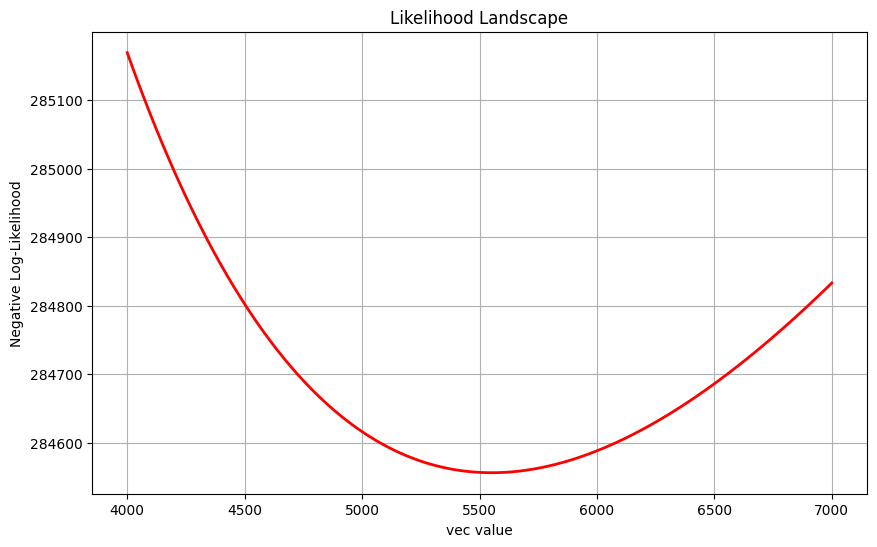

In [9]:
import jax.numpy as jnp
paths = {
    frozenset({
        ('demes', 0, 'epochs', 0, 'end_size'),
        ('demes', 0, 'epochs', 0, 'start_size'),
    }): 4000.,
}
vec_values = jnp.linspace(4000, 7000, 100)
result = plot_iicr_likelihood(g, ts, paths, vec_values)
# print(result)

2025-08-16 13:58:00.183 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-16 13:58:00.185 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 13:58:00.185 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-16 13:58:00.190 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-16 13:58:00.191 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-16 13:58:00.192 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edg

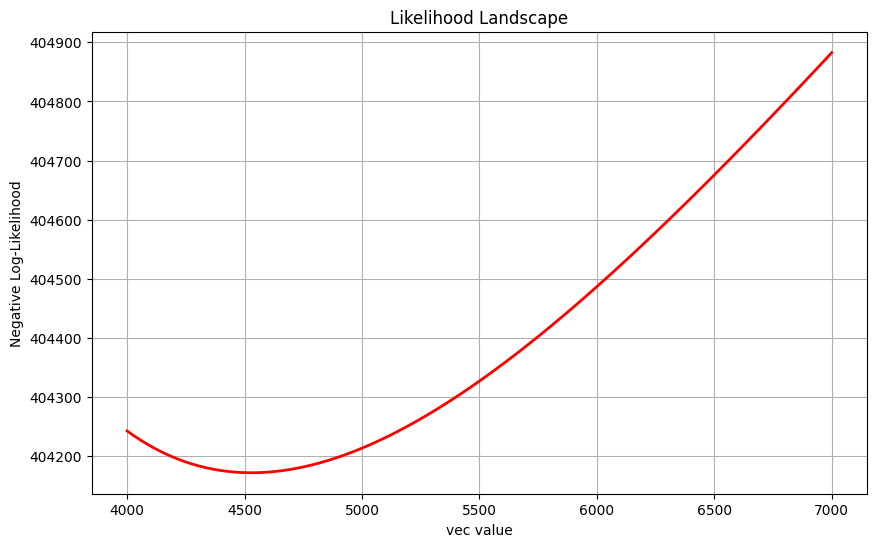

In [ ]:
import jax.numpy as jnp
paths = {
    frozenset({
        ('demes', 0, 'epochs', 0, 'end_size'),
        ('demes', 0, 'epochs', 0, 'start_size'),
    }): 4000.,
}
vec_values = jnp.linspace(4000, 7000, 100)
result = plot_sfs_likelihood(g, paths, vec_values, afs, afs_samples)

2025-08-16 14:18:47.517 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-16 14:18:47.518 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 14:18:47.518 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-16 14:18:47.519 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 14:18:47.519 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-16 14:18:47.520 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

146218.74205871913


2025-08-16 14:18:58.590 | DEBUG    | demesinfer.sfs.migration:lift_cm:71 - using diffeq solver for lift
2025-08-16 14:18:58.925 | DEBUG    | demesinfer.sfs.migration:lift_cm:71 - using diffeq solver for lift


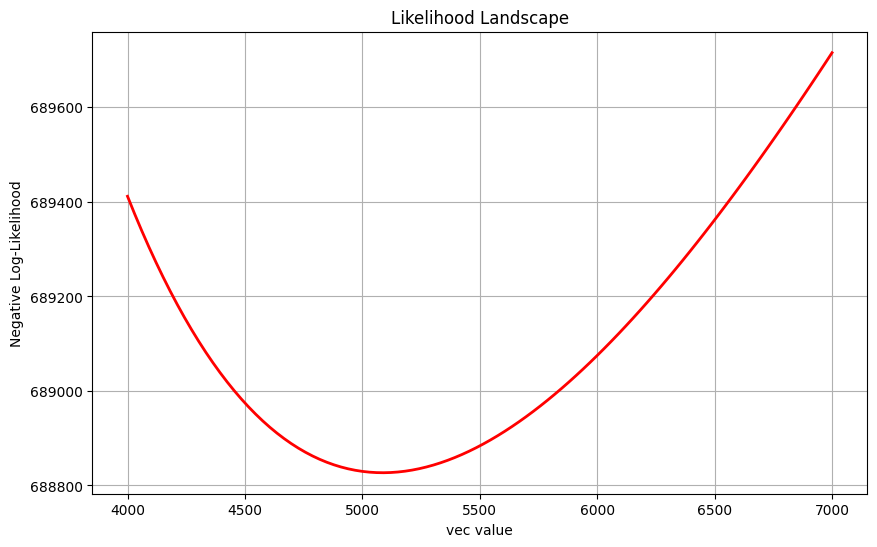

In [12]:
import jax.numpy as jnp
paths = {
    frozenset({
        ('demes', 0, 'epochs', 0, 'end_size'),
        ('demes', 0, 'epochs', 0, 'start_size'),
    }): 4000.,
}
vec_values = jnp.linspace(4000, 7000, 100)
result = plot_likelihood(g, ts, paths, vec_values, afs, afs_samples)

In [14]:
paths = {
    frozenset({
        ('demes', 0, 'epochs', 0, 'end_size'),
        ('demes', 0, 'epochs', 0, 'start_size'),
    }): 4000.,
}
# paths = {('migrations', 0, 'rate'): 0.001} 
result = fit(g, paths, ts, afs, afs_samples)
print(result)

2025-08-16 14:29:06.429 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-16 14:29:06.430 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 14:29:06.430 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-16 14:29:06.431 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-16 14:29:06.432 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-16 14:29:06.432 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edg

{frozenset({('demes', 0, 'epochs', 0, 'start_size'), ('demes', 0, 'epochs', 0, 'end_size')}): 5086.7698025475065}


In [8]:
paths = {
    frozenset({
        ('demes', 0, 'epochs', 0, 'end_size'),
        ('demes', 0, 'epochs', 0, 'start_size'),
    }): 8000.,
}
# paths = {('migrations', 0, 'rate'): 0.001} 
result = fit(g, paths, ts)
print(result)

2025-08-09 11:41:51.039 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-09 11:41:51.040 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 11:41:51.040 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-09 11:41:51.041 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-09 11:41:51.041 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edge 2 -> 3
2025-08-09 11:41:51.041 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edg

{frozenset({('demes', 0, 'epochs', 0, 'start_size'), ('demes', 0, 'epochs', 0, 'end_size')}): 5426.239421385543}


2025-08-16 14:50:33.656 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-16 14:50:33.657 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 14:50:33.657 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-16 14:50:33.658 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 14:50:33.658 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-16 14:50:33.658 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

146218.74205871913


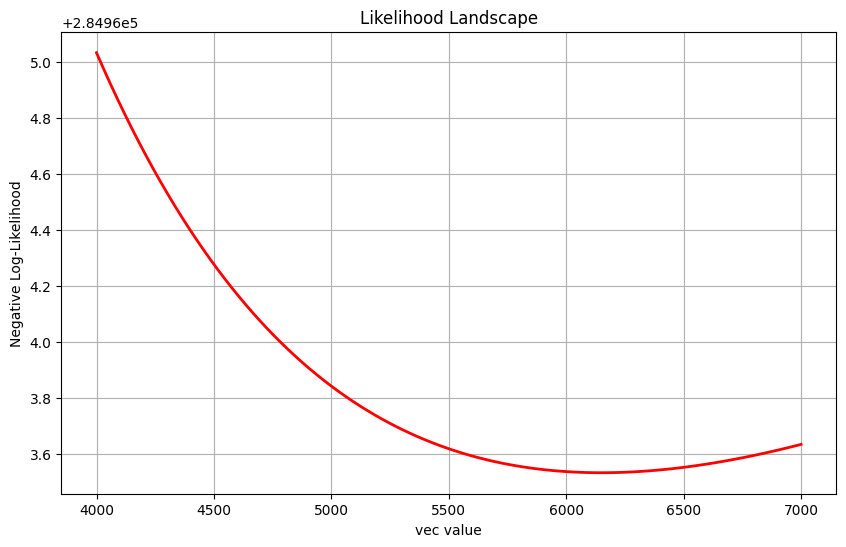

In [17]:
import jax.numpy as jnp
paths = {
    frozenset({
        ('demes', 1, 'epochs', 0, 'end_size'),
        ('demes', 1, 'epochs', 0, 'start_size'),
    }): 4000.,
}
vec_values = jnp.linspace(4000, 7000, 100)
result = plot_iicr_likelihood(g, ts, paths, vec_values, num_samples=100)
# print(result)

2025-08-16 14:53:49.764 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-16 14:53:49.766 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 14:53:49.766 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-16 14:53:49.781 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-16 14:53:49.783 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-16 14:53:49.783 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edg

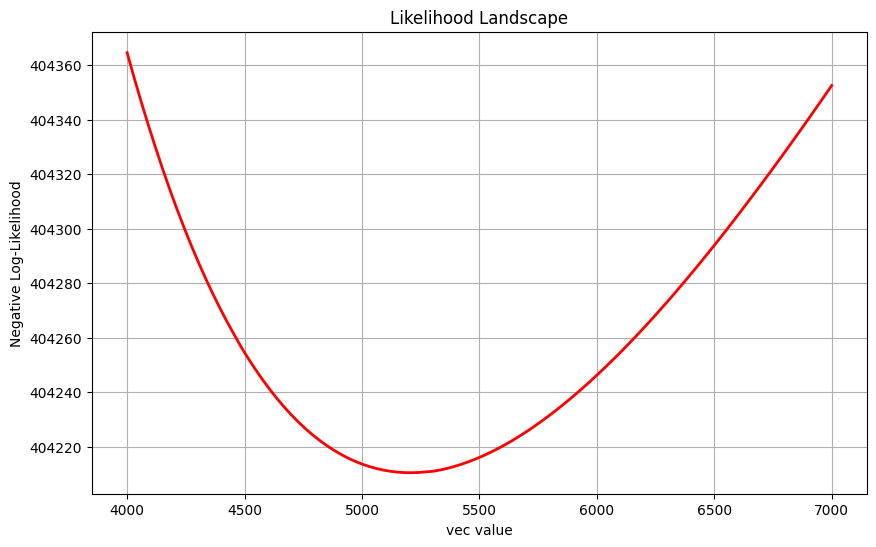

In [18]:
import jax.numpy as jnp
paths = {
    frozenset({
        ('demes', 1, 'epochs', 0, 'end_size'),
        ('demes', 1, 'epochs', 0, 'start_size'),
    }): 4000.,
}
vec_values = jnp.linspace(4000, 7000, 100)
result = plot_sfs_likelihood(g, paths, vec_values, afs, afs_samples)

2025-08-16 14:57:02.895 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-16 14:57:02.895 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 14:57:02.895 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-16 14:57:02.896 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 14:57:02.896 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-16 14:57:02.896 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

146218.74205871913


2025-08-16 14:59:53.146 | DEBUG    | demesinfer.sfs.migration:lift_cm:71 - using diffeq solver for lift
2025-08-16 15:00:01.558 | DEBUG    | demesinfer.sfs.migration:lift_cm:71 - using diffeq solver for lift


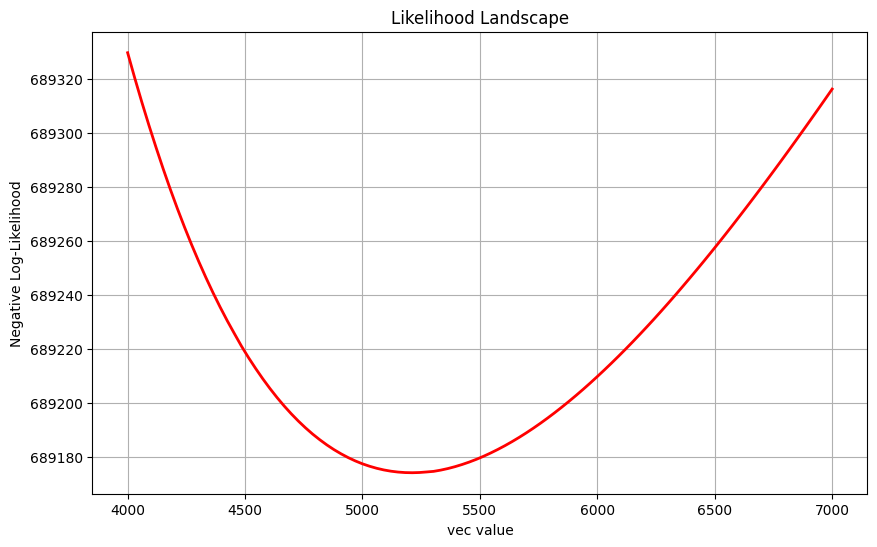

In [19]:
import jax.numpy as jnp
paths = {
    frozenset({
        ('demes', 1, 'epochs', 0, 'end_size'),
        ('demes', 1, 'epochs', 0, 'start_size'),
    }): 4000.,
}
vec_values = jnp.linspace(4000, 7000, 100)
result = plot_likelihood(g, ts, paths, vec_values, afs, afs_samples, num_samples = 100)

In [10]:
paths = {
    frozenset({
        ('demes', 1, 'epochs', 0, 'end_size'),
        ('demes', 1, 'epochs', 0, 'start_size'),
    }): 7000.,
}
# paths = {('migrations', 0, 'rate'): 0.001} 
result = fit(g, paths, ts)
print(result)

2025-08-09 11:54:44.259 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-09 11:54:44.259 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 11:54:44.259 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-09 11:54:44.261 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-09 11:54:44.261 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edge 2 -> 3
2025-08-09 11:54:44.262 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edg

{frozenset({('demes', 1, 'epochs', 0, 'start_size'), ('demes', 1, 'epochs', 0, 'end_size')}): 5619.768399709504}


2025-08-17 13:04:22.355 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-17 13:04:22.358 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 13:04:22.358 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-17 13:04:22.360 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 13:04:22.360 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-17 13:04:22.361 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

146218.74205871913


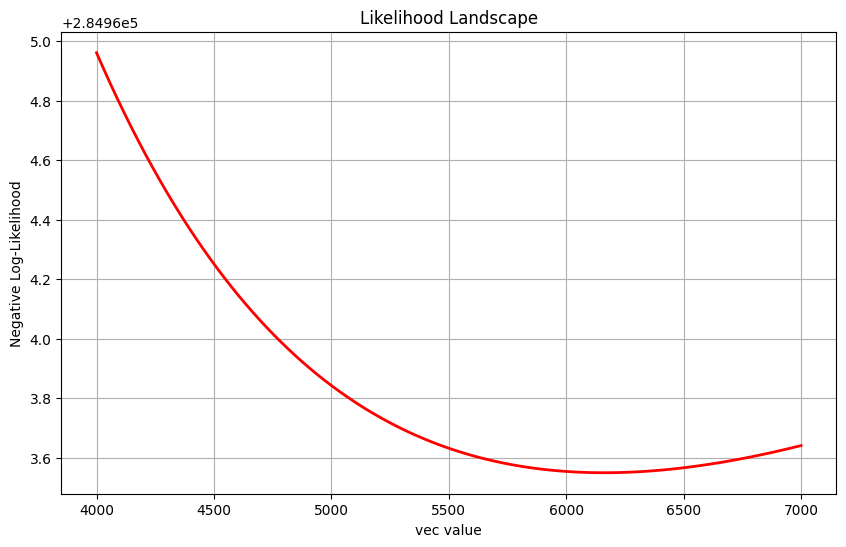

In [20]:
import jax.numpy as jnp
paths = {
    frozenset({
        ('demes', 2, 'epochs', 0, 'end_size'),
        ('demes', 2, 'epochs', 0, 'start_size'),
    }): 4000.,
}
vec_values = jnp.linspace(4000, 7000, 100)
result = plot_iicr_likelihood(g, ts, paths, vec_values, num_samples=100)
# print(result)

2025-08-17 13:07:50.363 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-17 13:07:50.366 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 13:07:50.367 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-17 13:07:50.378 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-17 13:07:50.379 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-17 13:07:50.380 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edg

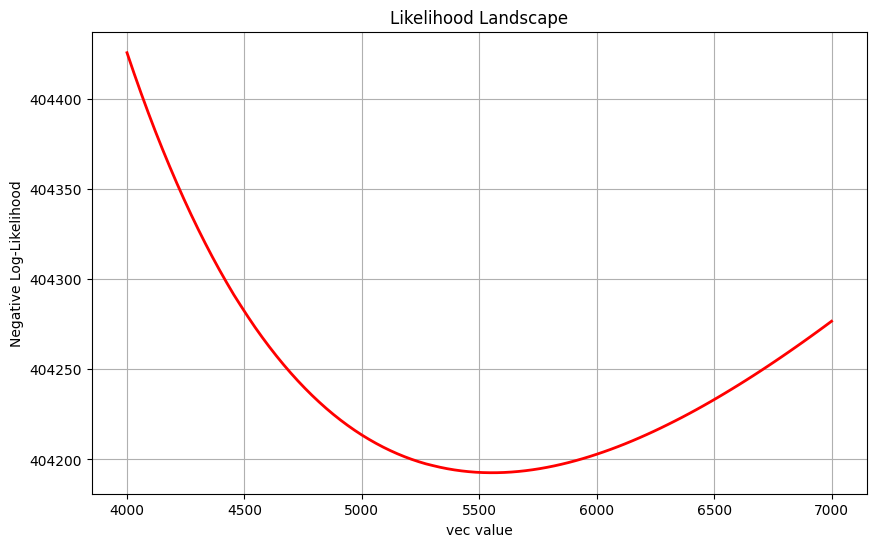

In [21]:
paths = {
    frozenset({
        ('demes', 2, 'epochs', 0, 'end_size'),
        ('demes', 2, 'epochs', 0, 'start_size'),
    }): 4000.,
}
vec_values = jnp.linspace(4000, 7000, 100)
result = plot_sfs_likelihood(g, paths, vec_values, afs, afs_samples)

146218.74205871913


2025-08-17 13:13:39.510 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-17 13:13:39.511 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 13:13:39.511 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-17 13:13:39.511 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 13:13:39.511 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-17 13:13:39.512 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

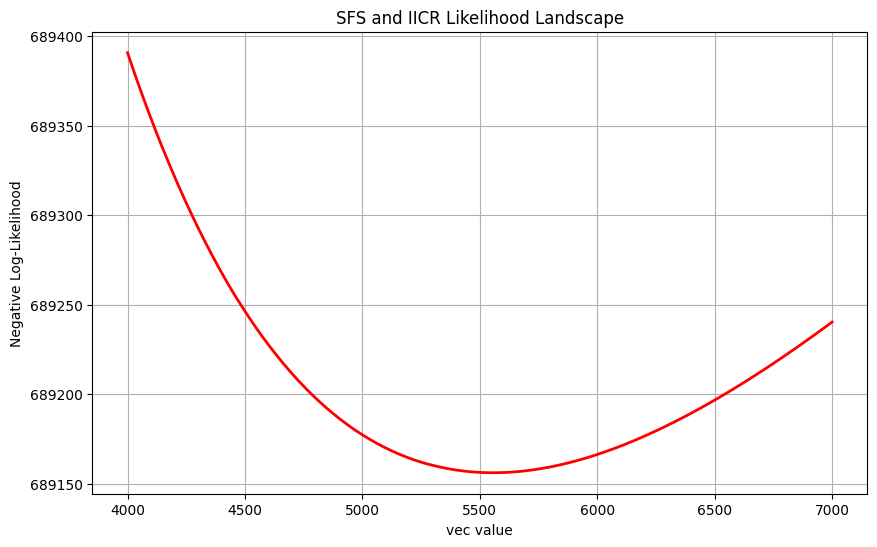

In [4]:
import jax.numpy as jnp
paths = {
    frozenset({
        ('demes', 2, 'epochs', 0, 'end_size'),
        ('demes', 2, 'epochs', 0, 'start_size'),
    }): 4000.,
}
vec_values = jnp.linspace(4000, 7000, 100)
result = plot_likelihood(g, ts, paths, vec_values, afs, afs_samples, num_samples=100)
# print(result)

In [ ]:
paths = {
    frozenset({
        ('demes', 2, 'epochs', 0, 'end_size'),
        ('demes', 2, 'epochs', 0, 'start_size'),
    }): 4000.,
}
result = fit(g, paths, ts, afs, afs_samples, num_samples = 100)
print(result)

2025-08-09 12:11:15.197 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-09 12:11:15.198 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 12:11:15.198 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-09 12:11:15.200 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-09 12:11:15.200 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edge 2 -> 3
2025-08-09 12:11:15.200 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edg

{frozenset({('demes', 2, 'epochs', 0, 'start_size'), ('demes', 2, 'epochs', 0, 'end_size')}): 5200.519598672061}


146218.74205871913


2025-08-17 13:38:20.506 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-17 13:38:20.507 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 13:38:20.507 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-17 13:38:20.507 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 13:38:20.507 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-17 13:38:20.508 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

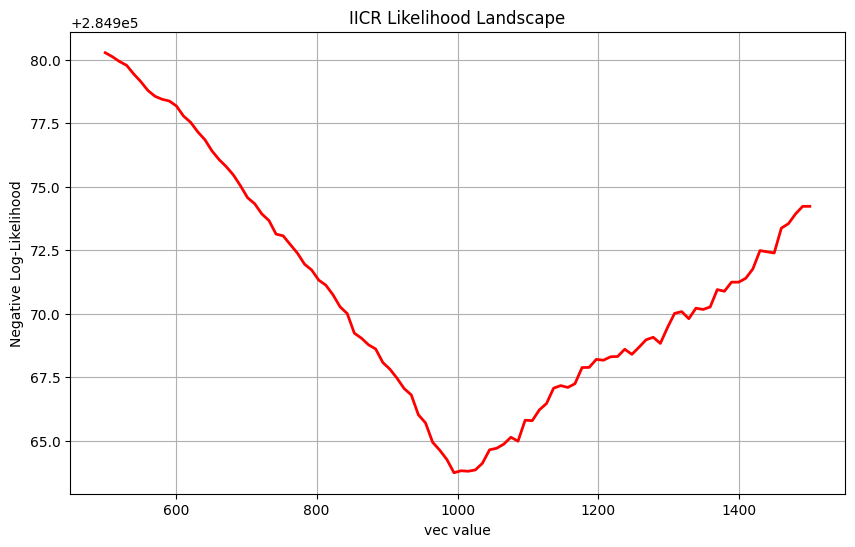

In [5]:
paths = {
    frozenset({('demes', 0, 'epochs', 0, 'end_time'),
            ('demes', 1, 'start_time'),
            ('demes', 2, 'start_time'),
            ('migrations', 0, 'start_time'),
            ('migrations', 1, 'start_time')}): 500.,
}
vec_values = jnp.linspace(500, 1500, 100)
result = plot_iicr_likelihood(g, ts, paths, vec_values, num_samples=100, num_t=4000)

2025-08-17 14:02:00.337 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-17 14:02:00.339 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 14:02:00.340 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-17 14:02:00.342 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('migrations', 0, 'end_time')}
2025-08-17 14:02:00.343 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-17 14:02:00.343 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edg

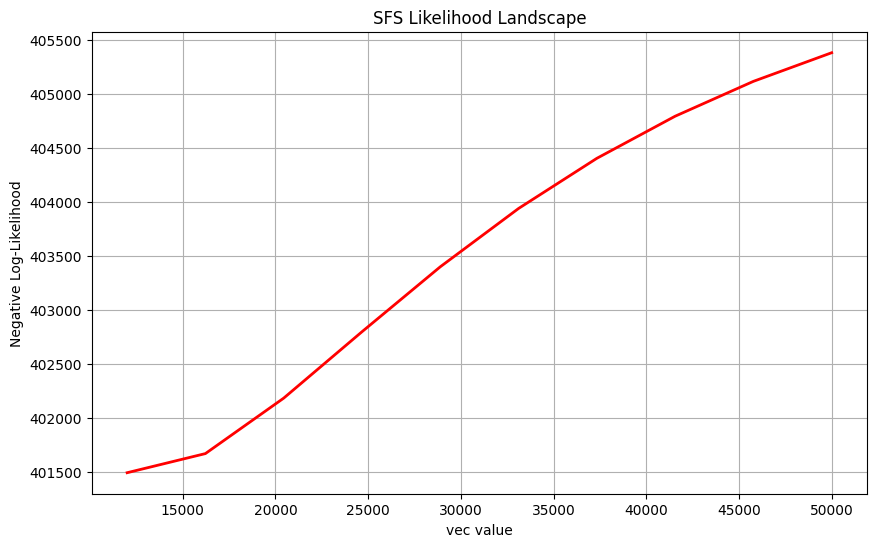

In [9]:
paths = {
    frozenset({('demes', 0, 'epochs', 0, 'end_time'),
            ('demes', 1, 'start_time'),
            ('demes', 2, 'start_time'),
            ('migrations', 0, 'start_time'),
            ('migrations', 1, 'start_time')}): 500.,
}
vec_values = jnp.linspace(500, 1500, 10)
result = plot_sfs_likelihood(g, paths, vec_values, afs, afs_samples)

2025-08-17 14:09:46.478 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-17 14:09:46.478 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 14:09:46.478 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-17 14:09:46.479 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 14:09:46.479 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-17 14:09:46.479 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

146218.74205871913


2025-08-17 14:22:44.342 | DEBUG    | demesinfer.sfs.migration:lift_cm:71 - using diffeq solver for lift
2025-08-17 14:22:44.834 | DEBUG    | demesinfer.sfs.migration:lift_cm:71 - using diffeq solver for lift


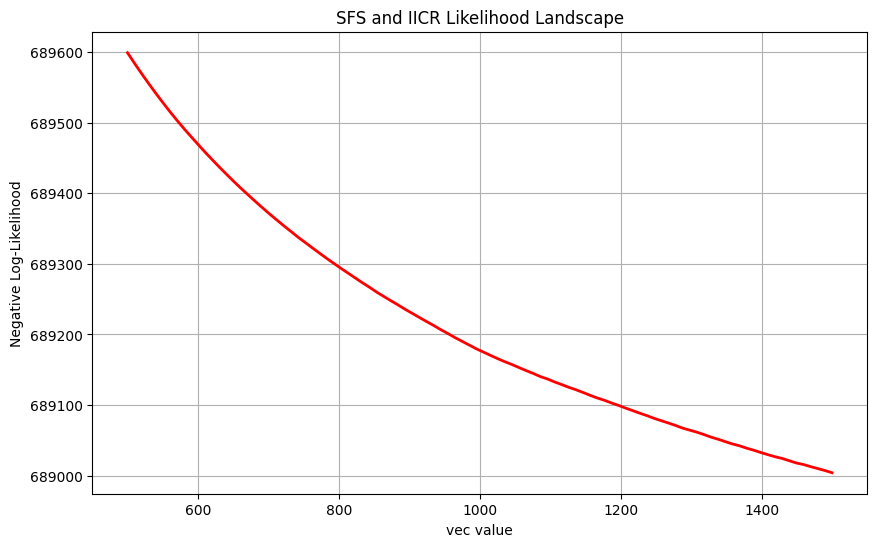

In [10]:
paths = {
    frozenset({('demes', 0, 'epochs', 0, 'end_time'),
            ('demes', 1, 'start_time'),
            ('demes', 2, 'start_time'),
            ('migrations', 0, 'start_time'),
            ('migrations', 1, 'start_time')}): 500.,
}
vec_values = jnp.linspace(500, 1500, 100)
result = plot_likelihood(g, ts, paths, vec_values, afs, afs_samples, num_samples=100, num_t=4000)

In [ ]:
paths = {
    frozenset({('demes', 0, 'epochs', 0, 'end_time'),
            ('demes', 1, 'start_time'),
            ('demes', 2, 'start_time'),
            ('migrations', 0, 'start_time'),
            ('migrations', 1, 'start_time')}): 500.,
}
# paths = {('migrations', 0, 'rate'): 0.001} 
result = fit(g, paths, ts, afs, afs_samples, num_samples=100, num_t=4000)
print(result)

2025-08-09 12:37:23.751 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-09 12:37:23.752 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 12:37:23.752 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-09 12:37:23.762 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-09 12:37:23.763 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edge 2 -> 3
2025-08-09 12:37:23.763 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edg

{frozenset({('migrations', 1, 'start_time'), ('demes', 0, 'epochs', 0, 'end_time'), ('migrations', 0, 'start_time'), ('demes', 1, 'start_time'), ('demes', 2, 'start_time')}): 500.00017777787116}


2025-08-17 14:42:48.419 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-17 14:42:48.420 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 14:42:48.420 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-17 14:42:48.421 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 14:42:48.421 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-17 14:42:48.422 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

146218.74205871913


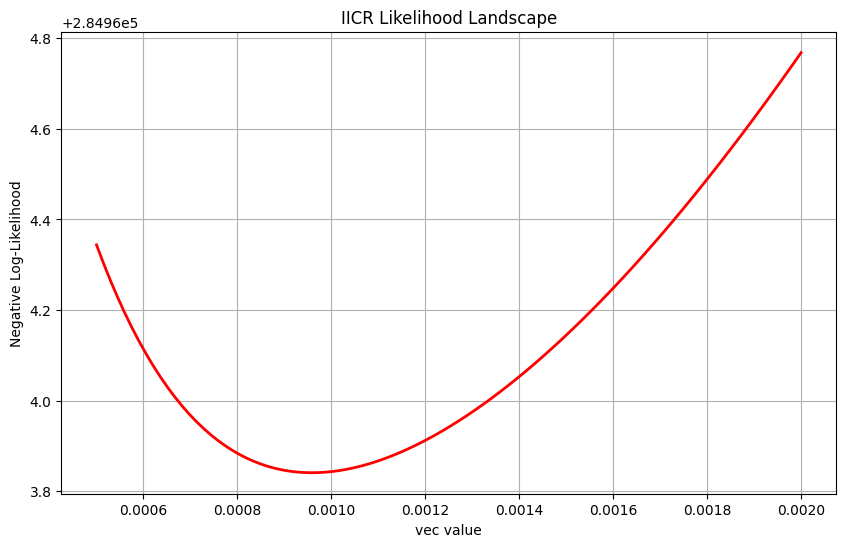

In [12]:
vec_values = jnp.linspace(0.0005, 0.002, 100)
paths = {('migrations', 0, 'rate'): 0.5} 
result = plot_iicr_likelihood(g, ts, paths, vec_values, num_samples=100)

2025-08-17 16:17:04.712 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-17 16:17:04.733 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 16:17:04.735 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-17 16:17:04.766 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('migrations', 0, 'end_time')}
2025-08-17 16:17:04.766 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-17 16:17:04.767 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edg

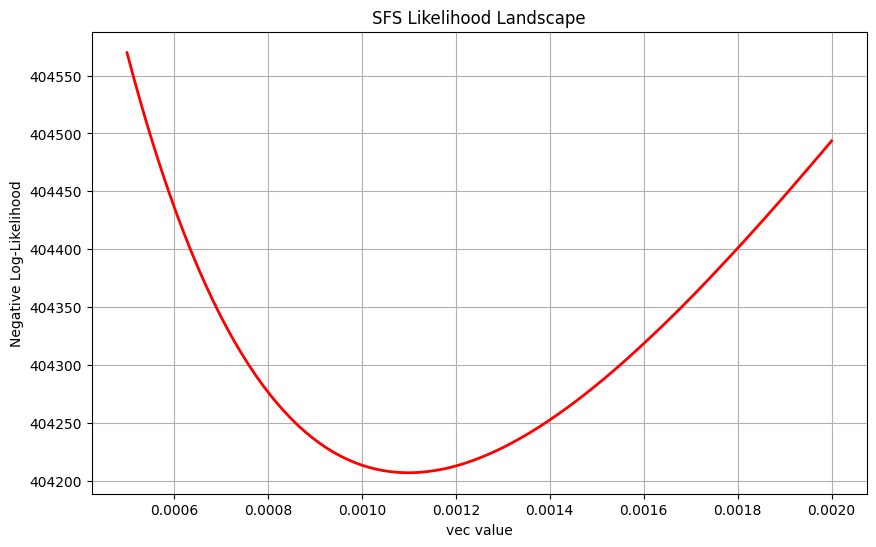

In [13]:
vec_values = jnp.linspace(0.0005, 0.002, 100)
paths = {('migrations', 0, 'rate'): 0.5} 
result = plot_sfs_likelihood(g, paths, vec_values, afs, afs_samples)

2025-08-17 16:20:25.884 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-17 16:20:25.884 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 16:20:25.884 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-17 16:20:25.884 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-17 16:20:25.885 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-17 16:20:25.885 | DEBUG    | demesinfer.event_tree:_add_edge:484 - ad

146218.74205871913


2025-08-17 16:23:45.388 | DEBUG    | demesinfer.sfs.migration:lift_cm:71 - using diffeq solver for lift
2025-08-17 16:23:45.916 | DEBUG    | demesinfer.sfs.migration:lift_cm:71 - using diffeq solver for lift


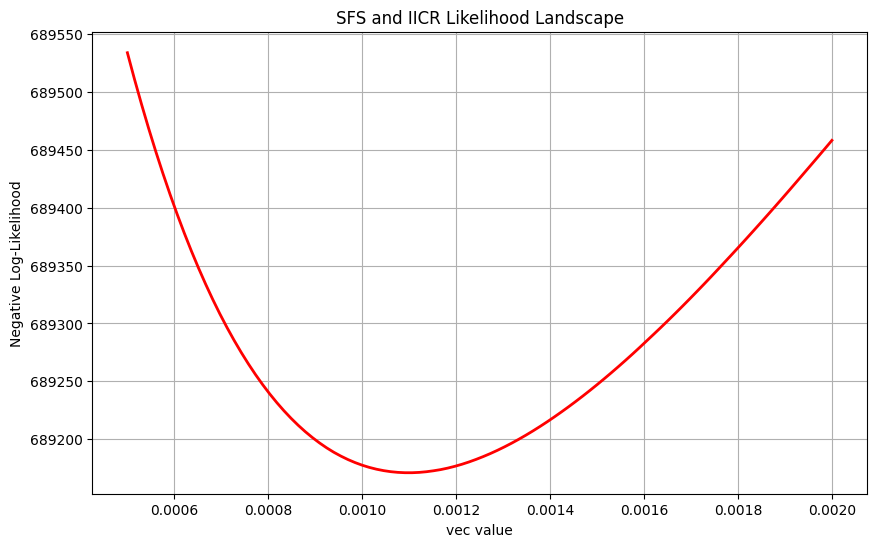

In [14]:
import jax.numpy as jnp
vec_values = jnp.linspace(0.0005, 0.002, 100)
paths = {('migrations', 0, 'rate'): 0.5} 
result = plot_likelihood(g, ts, paths, vec_values, afs, afs_samples, num_samples=100)
# print(result)

## Ignore Everything Below

2025-08-09 12:49:46.805 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-09 12:49:46.806 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 12:49:46.806 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-09 12:49:46.807 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 12:49:46.807 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edge 2 -> 3
2025-08-09 12:49:46.807 | DEBUG    | demesinfer.event_tree:_add_edge:472 - ad

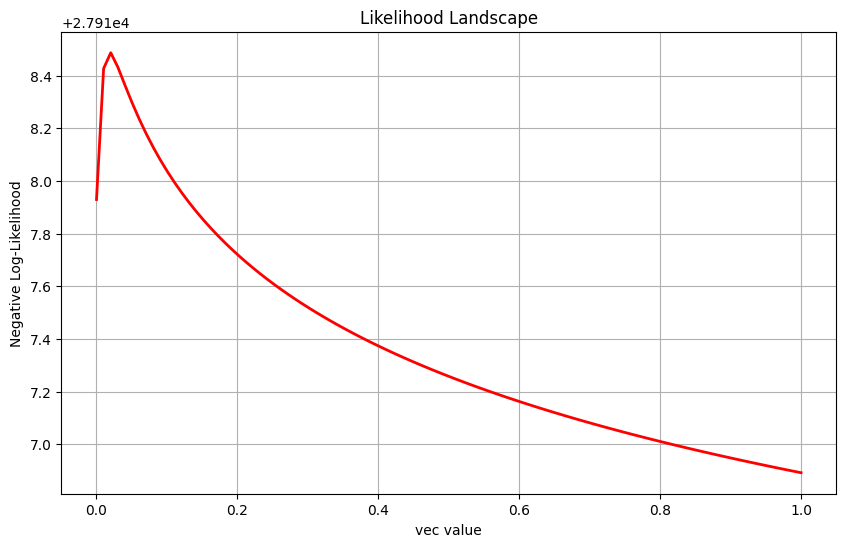

In [25]:
import jax.numpy as jnp
vec_values = jnp.linspace(0.001, 1.0, 100)
paths = {('migrations', 0, 'rate'): 0.5} 
result = plot_likelihood(g, ts, paths, vec_values, num_samples = 150)
# print(result)

In [28]:
from __future__ import annotations

from typing import Any, Dict, List, Mapping, Optional, Sequence, Set, Tuple

import jax
import jax.numpy as jnp
import msprime as msp
from scipy.optimize import LinearConstraint, minimize
import jax.random as jr
from jax import vmap 

from demesinfer.coal_rate import PiecewiseConstant
from demesinfer.constr import EventTree, constraints_for
from demesinfer.iicr import IICRCurve
from demesinfer.loglik.arg import loglik
from scipy.optimize import Bounds

Path = Tuple[Any, ...]
Var = Path | Set[Path]
Params = Mapping[Var, float]

def _dict_to_vec(d: Params, keys: Sequence[Var]) -> jnp.ndarray:
    return jnp.asarray([d[k] for k in keys], dtype=jnp.float64)

def _vec_to_dict_jax(v: jnp.ndarray, keys: Sequence[Var]) -> Dict[Var, jnp.ndarray]:
    return {k: v[i] for i, k in enumerate(keys)}

def _vec_to_dict(v: jnp.ndarray, keys: Sequence[Var]) -> Dict[Var, float]:
    return {k: float(v[i]) for i, k in enumerate(keys)}

def compile(ts, subkey):
    # using a set to pull out all unique populations that the samples can possibly belong to
    pop_cfg = {ts.population(ts.node(n).population).metadata["name"] for n in ts.samples()}
    pop_cfg = {pop_name: 0 for pop_name in pop_cfg}

    samples = jax.random.choice(subkey, ts.num_samples, shape=(2,), replace=False)
    a, b = samples[0].item(0), samples[1].item(0)
    tmp = pop_cfg.copy()
    spans = []
    curr_t = None
    curr_L = 0.0
    for tree in ts.trees():
        L = tree.interval.right - tree.interval.left
        t = tree.tmrca(a, b)
        if curr_t is None or t != curr_t:
            if curr_t is not None:
                spans.append([curr_t, curr_L])
            curr_t = t
            curr_L = L
        else:
            curr_L += L
    spans.append([curr_t, curr_L])
    data = jnp.asarray(spans, dtype=jnp.float64)
    tmp[ts.population(ts.node(a).population).metadata["name"]] += 1
    tmp[ts.population(ts.node(b).population).metadata["name"]] += 1
    return data, tmp

def get_tmrca_data(ts, key, num_samples):
    data_list = []
    cfg_list = []
    for i in range(num_samples):
        key, subkey = jr.split(key)
        data, cfg = compile(ts, subkey)
        data_list.append(data)
        cfg_list.append(cfg)

    lens = jnp.array([d.shape[0] for d in data_list], dtype=jnp.int32)
    Lmax = int(lens.max())
    Npairs = len(data_list)
    data_pad = jnp.full((Npairs, Lmax, 2), jnp.array([1.0, 0.0]), dtype=jnp.float64)

    for i, d in enumerate(data_list):
        data_pad = data_pad.at[i, : d.shape[0], :].set(d)

    deme_names = cfg_list[0].keys()
    D = len(deme_names)
    cfg_mat = jnp.zeros((num_samples, D), dtype=jnp.int32)
    for i, cfg in enumerate(cfg_list):
        for j, n in enumerate(deme_names):
            cfg_mat = cfg_mat.at[i, j].set(cfg.get(n, 0))
    
    return data_pad, cfg_mat, deme_names

def plot_likelihood(demo, ts, paths, vec_values, recombination_rate=1e-8, seed=1, num_samples=20, t_min=1e-8, num_t=1000, k=2):
    import matplotlib.pyplot as plt

    key = jr.PRNGKey(seed)
    path_order: List[Var] = list(paths)
    data_pad, cfg_mat, deme_names = get_tmrca_data(ts, key, num_samples)
    first_columns = data_pad[:, :, 0]
    # Compute global max (single float value)
    global_max = jnp.max(first_columns)
    t_breaks = jnp.linspace(t_min, global_max * 2, num_t)
    rho = recombination_rate
    iicr = IICRCurve(demo=demo, k=k)
    iicr_call = jax.jit(iicr.__call__)

    def compute_loglik(vec, sample_config, data):
        # Convert sample_config (array) to dictionary of population sizes
        ns = {name: sample_config[i] for i, name in enumerate(deme_names)}
        
        # Initialize params (assuming fixed for all samples)
        params = _vec_to_dict_jax(vec, path_order)
        
        # Compute IICR and log-likelihood
        c = iicr_call(params=params, t=t_breaks, num_samples=ns)["c"]
        eta = PiecewiseConstant(c=c, t=t_breaks)
        return loglik(eta, rho, data)
    
    def evaluate_at_vec(vec):
        vec_array = jnp.atleast_1d(vec)
        # Batched over cfg_mat and all_tmrca_spans 
        batched_loglik = vmap(compute_loglik, in_axes=(None, 0, 0))(vec_array, cfg_mat, data_pad)
        return -jnp.sum(batched_loglik) / num_samples  # Same as original neg_loglik

    # Outer vmap: Parallelize across vec_values
    batched_neg_loglik = vmap(evaluate_at_vec)  # in_axes=0 is default

    # 3. Compute all values (runs on GPU/TPU if available)
    results = batched_neg_loglik(vec_values) 

    # 4. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(vec_values, results, 'r-', linewidth=2)
    plt.xlabel("vec value")
    plt.ylabel("Negative Log-Likelihood")
    plt.title("Likelihood Landscape")
    plt.grid(True)
    plt.show()

    return results

def fit(
    demo,
    paths: Params,
    ts,
    *,
    k: int = 2,
    n_samples: int = 10,
    t_min: float = 1e-8,
    # t_max: float,
    num_t: int = 1000,
    method: str = "trust-constr",
    options: Optional[dict] = None,
    recombination_rate: float = 1e-8,
    sequence_length: float = 1e7,
    mutation_rate: float = 1e-8,
    seed: int = 1,
    num_samples = 20,
):
    key = jr.PRNGKey(seed)
    # msp_demo = msp.Demography.from_demes(demo)
    # deme_names = [d.name for d in demo.demes]
    # samples = {d: n_samples for d in deme_names[1:]}
    # ts = msp.sim_mutations(
    #     msp.sim_ancestry(
    #         samples=samples,
    #         demography=msp_demo,
    #         recombination_rate=recombination_rate,
    #         sequence_length=sequence_length,
    #         random_seed=seed,
    #     ),
    #     rate=mutation_rate,
    #     random_seed=seed + 1,
    # )

    data_pad, cfg_mat, deme_names = get_tmrca_data(ts, key, num_samples)

    path_order: List[Var] = list(paths)
    x0 = _dict_to_vec(paths, path_order)
    et = EventTree(demo)

    cons = constraints_for(et, *path_order)
    linear_constraints: list[LinearConstraint] = []

    Aeq, beq = cons["eq"]
    if Aeq.size:
        linear_constraints.append(LinearConstraint(Aeq, beq, beq))

    G, h = cons["ineq"]
    if G.size:
        lower = -jnp.inf * jnp.ones_like(h)
        linear_constraints.append(LinearConstraint(G, lower, h))

    first_columns = data_pad[:, :, 0]
    # Compute global max (single float value)
    global_max = jnp.max(first_columns)
    t_breaks = jnp.linspace(t_min, global_max * 2, num_t)
    rho = recombination_rate
    iicr = IICRCurve(demo=demo, k=k)
    iicr_call = jax.jit(iicr.__call__)

    def compute_loglik(vec, sample_config, data):
        # Convert sample_config (array) to dictionary of population sizes
        ns = {name: sample_config[i] for i, name in enumerate(deme_names)}
        
        # Initialize params (assuming fixed for all samples)
        params = _vec_to_dict_jax(vec, path_order)
        
        # Compute IICR and log-likelihood
        c = iicr_call(params=params, t=t_breaks, num_samples=ns)["c"]
        eta = PiecewiseConstant(c=c, t=t_breaks)
        return loglik(eta, rho, data)
    
    @jax.value_and_grad
    def neg_loglik(vec):
        vec = vec
        batched_loglik = vmap(
        compute_loglik,
        in_axes=(None, 0, 0))(vec, cfg_mat, data_pad)
        
        likelihood = jnp.sum(batched_loglik)

        return -likelihood / num_samples

    res = minimize(
        fun=lambda x: float(neg_loglik(x)[0]),
        # fun=lambda x: float(neg_loglik(x)),
        x0=jnp.asarray(x0),
        jac=lambda x: jnp.asarray(neg_loglik(x)[1], dtype=float),
        method=method,
        bounds = Bounds(lb=0.0005, ub=0.003),
        constraints=linear_constraints,
    )

    return _vec_to_dict(jnp.asarray(res.x), path_order)


In [29]:
paths = {('migrations', 0, 'rate'): 0.001} 
result = fit(g, paths, ts, num_samples = 150)
print(result)

2025-08-09 13:14:54.602 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-09 13:14:54.602 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 13:14:54.603 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-09 13:14:54.604 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-09 13:14:54.604 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edge 2 -> 3
2025-08-09 13:14:54.604 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edg

{('migrations', 0, 'rate'): 0.0019312128015554653}


In [30]:
from __future__ import annotations

from typing import Any, Dict, List, Mapping, Optional, Sequence, Set, Tuple

import jax
import jax.numpy as jnp
import msprime as msp
from scipy.optimize import LinearConstraint, minimize
import jax.random as jr
from jax import vmap 

from demesinfer.coal_rate import PiecewiseConstant
from demesinfer.constr import EventTree, constraints_for
from demesinfer.iicr import IICRCurve
from demesinfer.loglik.arg import loglik

Path = Tuple[Any, ...]
Var = Path | Set[Path]
Params = Mapping[Var, float]

def _dict_to_vec(d: Params, keys: Sequence[Var]) -> jnp.ndarray:
    return jnp.asarray([d[k] for k in keys], dtype=jnp.float64)

def _vec_to_dict_jax(v: jnp.ndarray, keys: Sequence[Var]) -> Dict[Var, jnp.ndarray]:
    return {k: v[i] for i, k in enumerate(keys)}

def _vec_to_dict(v: jnp.ndarray, keys: Sequence[Var]) -> Dict[Var, float]:
    return {k: float(v[i]) for i, k in enumerate(keys)}

def compile(ts, subkey):
    # using a set to pull out all unique populations that the samples can possibly belong to
    pop_cfg = {ts.population(ts.node(n).population).metadata["name"] for n in ts.samples()}
    pop_cfg = {pop_name: 0 for pop_name in pop_cfg}

    samples = jax.random.choice(subkey, ts.num_samples, shape=(2,), replace=False)
    a, b = samples[0].item(0), samples[1].item(0)
    tmp = pop_cfg.copy()
    spans = []
    curr_t = None
    curr_L = 0.0
    for tree in ts.trees():
        L = tree.interval.right - tree.interval.left
        t = tree.tmrca(a, b)
        if curr_t is None or t != curr_t:
            if curr_t is not None:
                spans.append([curr_t, curr_L])
            curr_t = t
            curr_L = L
        else:
            curr_L += L
    spans.append([curr_t, curr_L])
    data = jnp.asarray(spans, dtype=jnp.float64)
    tmp[ts.population(ts.node(a).population).metadata["name"]] += 1
    tmp[ts.population(ts.node(b).population).metadata["name"]] += 1
    return data, tmp

def get_tmrca_data(ts, key, num_samples):
    data_list = []
    cfg_list = []
    for i in range(num_samples):
        key, subkey = jr.split(key)
        data, cfg = compile(ts, subkey)
        data_list.append(data)
        cfg_list.append(cfg)

    lens = jnp.array([d.shape[0] for d in data_list], dtype=jnp.int32)
    Lmax = int(lens.max())
    Npairs = len(data_list)
    data_pad = jnp.full((Npairs, Lmax, 2), jnp.array([1.0, 0.0]), dtype=jnp.float64)

    for i, d in enumerate(data_list):
        data_pad = data_pad.at[i, : d.shape[0], :].set(d)

    deme_names = cfg_list[0].keys()
    D = len(deme_names)
    cfg_mat = jnp.zeros((num_samples, D), dtype=jnp.int32)
    for i, cfg in enumerate(cfg_list):
        for j, n in enumerate(deme_names):
            cfg_mat = cfg_mat.at[i, j].set(cfg.get(n, 0))
    
    return data_pad, cfg_mat, deme_names

def plot_likelihood(demo, ts, paths, vec_values, recombination_rate=1e-8, seed=1, num_samples=20, t_min=1e-8, num_t=1000, k=2):
    import matplotlib.pyplot as plt

    key = jr.PRNGKey(seed)
    path_order: List[Var] = list(paths)
    data_pad, cfg_mat, deme_names = get_tmrca_data(ts, key, num_samples)
    first_columns = data_pad[:, :, 0]
    # Compute global max (single float value)
    global_max = jnp.max(first_columns)
    t_breaks = jnp.linspace(t_min, global_max * 2, num_t)
    rho = recombination_rate
    iicr = IICRCurve(demo=demo, k=k)
    iicr_call = jax.jit(iicr.__call__)

    def compute_loglik(vec, sample_config, data):
        # Convert sample_config (array) to dictionary of population sizes
        ns = {name: sample_config[i] for i, name in enumerate(deme_names)}
        
        # Initialize params (assuming fixed for all samples)
        params = _vec_to_dict_jax(vec, path_order)
        
        # Compute IICR and log-likelihood
        c = iicr_call(params=params, t=t_breaks, num_samples=ns)["c"]
        eta = PiecewiseConstant(c=c, t=t_breaks)
        return loglik(eta, rho, data)
    
    def evaluate_at_vec(vec):
        vec_array = jnp.atleast_1d(vec)
        # Batched over cfg_mat and all_tmrca_spans 
        batched_loglik = vmap(compute_loglik, in_axes=(None, 0, 0))(vec_array, cfg_mat, data_pad)
        return -jnp.sum(batched_loglik) / num_samples  # Same as original neg_loglik

    # Outer vmap: Parallelize across vec_values
    batched_neg_loglik = vmap(evaluate_at_vec)  # in_axes=0 is default

    # 3. Compute all values (runs on GPU/TPU if available)
    results = batched_neg_loglik(vec_values) 

    # 4. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(vec_values, results, 'r-', linewidth=2)
    plt.xlabel("vec value")
    plt.ylabel("Negative Log-Likelihood")
    plt.title("Likelihood Landscape")
    plt.grid(True)
    plt.show()

    return results

def fit(
    demo,
    paths: Params,
    ts,
    *,
    k: int = 2,
    n_samples: int = 10,
    t_min: float = 1e-8,
    # t_max: float,
    num_t: int = 1000,
    method: str = "trust-constr",
    options: Optional[dict] = None,
    recombination_rate: float = 1e-8,
    sequence_length: float = 1e7,
    mutation_rate: float = 1e-8,
    seed: int = 1,
    num_samples = 20,
):
    key = jr.PRNGKey(seed)
    # msp_demo = msp.Demography.from_demes(demo)
    # deme_names = [d.name for d in demo.demes]
    # samples = {d: n_samples for d in deme_names[1:]}
    # ts = msp.sim_mutations(
    #     msp.sim_ancestry(
    #         samples=samples,
    #         demography=msp_demo,
    #         recombination_rate=recombination_rate,
    #         sequence_length=sequence_length,
    #         random_seed=seed,
    #     ),
    #     rate=mutation_rate,
    #     random_seed=seed + 1,
    # )

    data_pad, cfg_mat, deme_names = get_tmrca_data(ts, key, num_samples)

    path_order: List[Var] = list(paths)
    x0 = _dict_to_vec(paths, path_order)
    et = EventTree(demo)

    cons = constraints_for(et, *path_order)
    linear_constraints: list[LinearConstraint] = []

    Aeq, beq = cons["eq"]
    if Aeq.size:
        linear_constraints.append(LinearConstraint(Aeq, beq, beq))

    G, h = cons["ineq"]
    if G.size:
        lower = -jnp.inf * jnp.ones_like(h)
        linear_constraints.append(LinearConstraint(G, lower, h))

    first_columns = data_pad[:, :, 0]
    # Compute global max (single float value)
    global_max = jnp.max(first_columns)
    t_breaks = jnp.linspace(t_min, global_max * 2, num_t)
    rho = recombination_rate
    iicr = IICRCurve(demo=demo, k=k)
    iicr_call = jax.jit(iicr.__call__)

    def compute_loglik(vec, sample_config, data):
        # Convert sample_config (array) to dictionary of population sizes
        ns = {name: sample_config[i] for i, name in enumerate(deme_names)}
        
        # Initialize params (assuming fixed for all samples)
        params = _vec_to_dict_jax(vec, path_order)
        
        # Compute IICR and log-likelihood
        c = iicr_call(params=params, t=t_breaks, num_samples=ns)["c"]
        eta = PiecewiseConstant(c=c, t=t_breaks)
        return loglik(eta, rho, data)
    
    @jax.value_and_grad
    def neg_loglik(vec):
        vec = vec
        batched_loglik = vmap(
        compute_loglik,
        in_axes=(None, 0, 0))(vec, cfg_mat, data_pad)
        
        likelihood = jnp.sum(batched_loglik)

        return -likelihood / num_samples

    res = minimize(
        fun=lambda x: float(neg_loglik(x)[0]),
        # fun=lambda x: float(neg_loglik(x)),
        x0=jnp.asarray(x0),
        jac=lambda x: jnp.asarray(neg_loglik(x)[1], dtype=float),
        method=method,
        # bounds = [(3000. / 5000., 7000. / 5000.)],
        constraints=linear_constraints,
    )

    return _vec_to_dict(jnp.asarray(res.x), path_order)


In [32]:
import jax.numpy as jnp
paths = {
    frozenset({
        ('demes', 0, 'epochs', 0, 'end_size'),
        ('demes', 0, 'epochs', 0, 'start_size'),
    }): 4000., frozenset({
        ('demes', 1, 'epochs', 0, 'end_size'),
        ('demes', 1, 'epochs', 0, 'start_size'),
    }): 4000., frozenset({
        ('demes', 2, 'epochs', 0, 'end_size'),
        ('demes', 2, 'epochs', 0, 'start_size'),
    }): 4000.,
}
result = fit(g, paths, ts, num_samples = 150)
print(result)

2025-08-09 13:39:22.251 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-09 13:39:22.252 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 13:39:22.252 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-09 13:39:22.254 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-09 13:39:22.254 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edge 2 -> 3
2025-08-09 13:39:22.255 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edg

{frozenset({('demes', 0, 'epochs', 0, 'start_size'), ('demes', 0, 'epochs', 0, 'end_size')}): 5567.232750254264, frozenset({('demes', 1, 'epochs', 0, 'start_size'), ('demes', 1, 'epochs', 0, 'end_size')}): 4942.276159759092, frozenset({('demes', 2, 'epochs', 0, 'start_size'), ('demes', 2, 'epochs', 0, 'end_size')}): 5490.422644516871}


2025-08-09 22:48:17.845 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-09 22:48:17.847 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 22:48:17.847 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-09 22:48:17.848 | DEBUG    | demesinfer.event_tree:_add_node:491 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-09 22:48:17.848 | DEBUG    | demesinfer.event_tree:_add_edge:472 - adding edge 2 -> 3
2025-08-09 22:48:17.848 | DEBUG    | demesinfer.event_tree:_add_edge:472 - ad

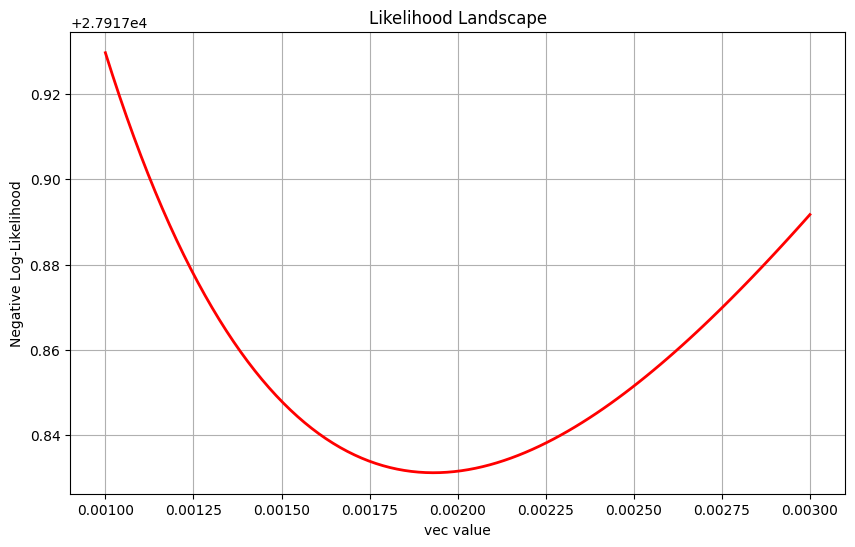

In [38]:
import jax.numpy as jnp
vec_values = jnp.linspace(0.001, 0.003, 100)
paths = {('migrations', 0, 'rate'): 0.5} 
result = plot_likelihood(g, ts, paths, vec_values, num_samples = 150)

In [3]:
from demesinfer.constr import constraints_for, EventTree
# demo = et.demodict
demo = g
et = EventTree(demo)
# cons = constraints(et)
et.variables

2025-08-15 10:38:31.773 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-15 10:38:31.776 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-15 10:38:31.777 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-15 10:38:31.789 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P0', 'P1'}), 't': ('migrations', 0, 'end_time')}
2025-08-15 10:38:31.794 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edge 2 -> 3
2025-08-15 10:38:31.797 | DEBUG    | demesinfer.event_tree:_add_edge:484 - adding edg

[frozenset({('demes', 0, 'epochs', 0, 'end_size'),
            ('demes', 0, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 1, 'epochs', 0, 'end_size'),
            ('demes', 1, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 2, 'epochs', 0, 'end_size'),
            ('demes', 2, 'epochs', 0, 'start_size')}),
 ('demes', 1, 'proportions', 0),
 ('demes', 2, 'proportions', 0),
 ('migrations', 0, 'rate'),
 ('migrations', 1, 'rate'),
 frozenset({('demes', 0, 'epochs', 0, 'end_time'),
            ('demes', 1, 'start_time'),
            ('demes', 2, 'start_time'),
            ('migrations', 0, 'start_time'),
            ('migrations', 1, 'start_time')}),
 frozenset({('demes', 1, 'epochs', 0, 'end_time'),
            ('demes', 2, 'epochs', 0, 'end_time'),
            ('migrations', 0, 'end_time'),
            ('migrations', 1, 'end_time')})]